In [77]:
# Clone Github
!git clone https://github.com/kragtenb/SelfDriving-RC-deep-learning.git

fatal: destination path 'SelfDriving-RC-deep-learning' already exists and is not an empty directory.


In [78]:
#%cd SelfDriving-RC-deep-learning/
!git pull origin main

fatal: not a git repository (or any of the parent directories): .git


In [79]:
!python -m venv colab-env
!source colab-env/bin/activate

In [80]:
!ls

+
amdgpu-install_6.0.60002-1_all.deb
amdgpu-install_6.0.60002-1_all.deb.1
amdgpu-install_6.0.60002-1_all.deb.2
colab-env
Desktop
Documents
Downloads
local_colab_runtime.bash
Music
path_to_project
path_to_project+
Pictures
Public
ROCm-docker
SelfDriving-RC-deep-learning
Templates
torch-2.1.2+rocm6.0-cp310-cp310-linux_x86_64.whl
torchvision-0.16.1+rocm6.0-cp310-cp310-linux_x86_64.whl
Videos


In [81]:
#path_to_project = '/home/blake/Documents/Github/SelfDriving-RC-deep-learning/'
path_to_project = 'SelfDriving-RC-deep-learning/'

In [82]:
# Here we are converting the pngs mask files to the class labels based
# on color (RGB).

def parse_labelmap(labelmap_path):
    color_to_class_id = {}
    class_id = 0  # Starting index for your classes
    with open(labelmap_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):  # Skip comments
                label, color, _, _ = line.strip().split(':')
                color_to_class_id[tuple(map(int, color.split(',')))] = class_id
                class_id += 1
    return color_to_class_id

color_to_class_id = parse_labelmap(path_to_project + "LabeledTraining/labelmap.txt")


In [83]:
print(color_to_class_id)

{(42, 125, 209): 0, (250, 50, 83): 1, (250, 250, 55): 2, (0, 0, 0): 3}


In [84]:
import torchvision
print(torchvision.__version__)

0.16.1+rocm6.0


In [85]:
# Dataset creation that matches images with the labeled annotations.
# Provides ability to transform images into a format that can be processed by
# pre-trained models

import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import ToPILImage

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list, labelmap_path, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        with open(image_list, 'r') as f:
            self.images = f.read().splitlines()
        self.color_to_class_id = self.parse_labelmap(labelmap_path)
        self.display_image = False

    # Here we are converting the pngs mask files to the class labels based
    # on color (RGB).

    def parse_labelmap(self, labelmap_path):
        color_to_class_id = {}
        class_id = 0  # Starting index for your classes
        with open(labelmap_path, 'r') as file:
            for line in file:
                if not line.startswith("#"):  # Skip comments
                    label, color, _, _ = line.strip().split(':')
                    color_to_class_id[tuple(map(int, color.split(',')))] = class_id
                    class_id += 1
        return color_to_class_id

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name + ".jpg")
        mask_path = os.path.join(self.mask_dir, img_name + ".png")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Apply the same transform to both image and mask
        seed = torch.random.initial_seed()  # Ensure same random transform applied

        if self.display_image == True:
          mask.show()
          image.show()

        if self.image_transform:
          torch.manual_seed(seed)
          image = self.image_transform(image)

        if self.mask_transform:
          # For masks, use a function that applies the necessary transforms
          # without changing the class integrity, like resizing with nearest neighbor
          torch.manual_seed(seed)
          mask = self.mask_transform(mask)

        if self.display_image == True:
          image_pil = ToPILImage()
          mask_pil = ToPILImage()
          image_pil(image).show()
          mask_pil(mask).show()
          self.display_image = False

        mask = self.convert_mask(mask)
        return image, mask

    def convert_mask(self, mask):
        """Convert a color-coded tensor to a class ID mask."""
        mask_array = np.transpose(np.array(mask.cpu().numpy()), (1, 2, 0))
        class_mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

        for color, class_id in self.color_to_class_id.items():
            # Find pixels matching this color and set their value to the class ID
            matches = np.all(mask_array == color, axis=-1)
            class_mask[matches] = class_id

        return torch.from_numpy(class_mask)

image_dir = path_to_project + "TrainingData/Images"
mask_dir = path_to_project + "LabeledTraining/SegmentationClass"
image_list = path_to_project + "LabeledTraining/ImageSets/Segmentation/default.txt"
labelmap_path = path_to_project + "LabeledTraining/labelmap.txt"
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),  # Ensure mask uses nearest neighbor
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
])
dataset = SegmentationDataset(image_dir, mask_dir, image_list, labelmap_path, image_transform=image_transform, mask_transform=mask_transform)
dataloader = DataLoader(dataset, num_workers=2, pin_memory=True, batch_size=8, shuffle=True)

In [86]:
# Defining the model to be used.
# Using a pre-trained model (resnet was recommended) to improve the image
# classification, instead of training a model from scratch which would take a
# long amount of time and would probably not be so robust.

import torch
import torchvision.models.segmentation as models

def get_deeplabv3_pretrained_model(num_classes):
    # Load a pre-trained DeepLabV3 model
    model = models.fcn_resnet50(pretrained=True)

    # Replace the classifier's last layer (This is to only give the classes
    # we are looking for instead of the 91 that comes from deeplabv3_resnet)
    model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

    # Replace the auxiliary classifier's last layer, if your model uses it
    if model.aux_classifier is not None:
        model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))

    return model

# Assuming you have 4 classes including background
num_classes = 4
model = get_deeplabv3_pretrained_model(num_classes)

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device, non_blocking=True)


/home/blake/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /home/blake/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
17.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

92.3%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
t

In [87]:
print(torch.cuda.is_available())

True


In [88]:
for images, masks in dataloader:
  print("Image Shape: " + str(images.shape))
  print("Masks Shape: " + str(masks.shape))

Image Shape: torch.Size([8, 3, 256, 256])
Masks Shape: torch.Size([8, 256, 256])
Image Shape: torch.Size([8, 3, 256, 256])
Masks Shape: torch.Size([8, 256, 256])
Image Shape: torch.Size([8, 3, 256, 256])
Masks Shape: torch.Size([8, 256, 256])
Image Shape: torch.Size([8, 3, 256, 256])
Masks Shape: torch.Size([8, 256, 256])
Image Shape: torch.Size([5, 3, 256, 256])
Masks Shape: torch.Size([5, 256, 256])


In [89]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, model=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.model = model
            self.counter = 0

In [90]:
import os
save_model_path = path_to_project + "DrivableVisionModel/"
if not os.path.exists(save_model_path):
  os.mkdir(save_model_path)

In [91]:
# Train my local images on a pre-trained image recognition model

import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0)
criterion = torch.nn.CrossEntropyLoss()
#save_model_path = path_to_project

torch.backends.cudnn.benchmark = True
num_epochs = 3000
model.train()
for epoch in range(num_epochs):
    for images, masks in dataloader:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

        model.zero_grad(set_to_none=True)

        # # Enable mixed precision for the forward pass only
        # with autocast():
        output = model(images)['out']
        loss = criterion(output, masks.long())

        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.data.cpu().numpy()}")
    #Early Stopping check
    early_stopping(loss, model.state_dict())
    if early_stopping.early_stop:
        print("Stopping training...")
        print("Saving Model DrivableModel_" + str(epoch) + ".torch")
        torch.save(early_stopping.model, save_model_path + "DrivableModel_" + str(epoch) + ".torch")
        break
    if epoch % 500 == 0:
        print("Saving Model DrivableModel_" + str(epoch) + ".torch")
        torch.save(early_stopping.model, save_model_path + "DrivableModel_" + str(epoch) + ".torch")


Epoch: 1, Loss: 1.0763708353042603
Saving Model DrivableModel_0.torch
Epoch: 2, Loss: 0.8428699374198914
Epoch: 3, Loss: 0.700376033782959
Epoch: 4, Loss: 0.612230122089386
Epoch: 5, Loss: 0.5742794275283813
Epoch: 6, Loss: 0.7329005002975464
EarlyStopping counter: 1 out of 10
Epoch: 7, Loss: 0.5772157907485962
EarlyStopping counter: 2 out of 10
Epoch: 8, Loss: 0.4888904094696045
Epoch: 9, Loss: 0.5047582387924194
EarlyStopping counter: 1 out of 10
Epoch: 10, Loss: 0.4892263412475586
EarlyStopping counter: 2 out of 10
Epoch: 11, Loss: 0.462458074092865
Epoch: 12, Loss: 0.4226232171058655
Epoch: 13, Loss: 0.3474029004573822
Epoch: 14, Loss: 0.325045108795166
Epoch: 15, Loss: 0.39380016922950745
EarlyStopping counter: 1 out of 10
Epoch: 16, Loss: 0.2722567915916443
Epoch: 17, Loss: 0.2766091525554657
EarlyStopping counter: 1 out of 10
Epoch: 18, Loss: 0.37351173162460327
EarlyStopping counter: 2 out of 10
Epoch: 19, Loss: 0.34684333205223083
EarlyStopping counter: 3 out of 10
Epoch: 20, 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


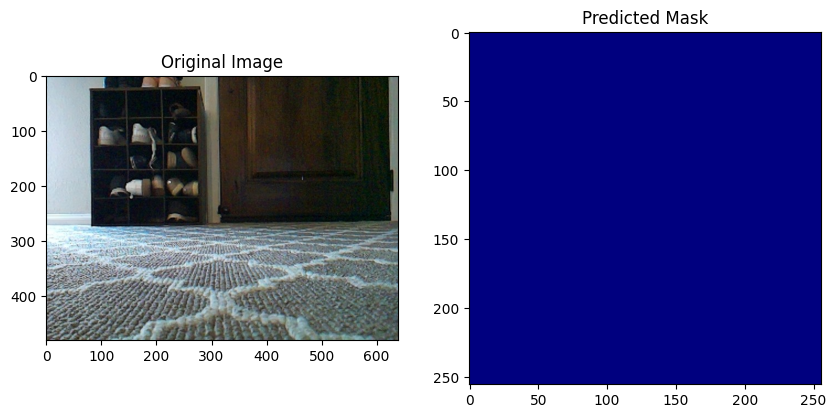

In [97]:
# Define the transformations. This should match your training preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Example resize to match model input
    transforms.ToTensor(),
    # Include any other preprocessing steps (e.g., normalization) used during training
])

test_image = image_dir + "/2024_03_25_T_11_05_58.jpg"

image = Image.open(test_image).convert('RGB')
image_tensor = transform(image).unsqueeze(0)

model.load_state_dict(torch.load(path_to_project + 'DrivableVisionModel/DrivableModel_131.torch'))

# Ensure model and data are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image_tensor = image_tensor.to(device)

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    output = model(image_tensor)['out']
    predicted_mask = torch.argmax(output, dim=1)  # Get the most likely class for each pixel

# Convert predicted_mask back to an image or a format that can be easily visualized or further processed
predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch dim and transfer to CPU

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# Predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='jet')  # Adjust colormap as needed
plt.title('Predicted Mask')
print(predicted_mask)

plt.show()